# **1. Install SplineDist and dependencies**
---


## **1.1. Install key dependencies**
---
<font size = 4> 

In [1]:
# pip install stardist==0.6.2 gputools edt wget fpdf PTable 
# git clone https://github.com/uhlmanngroup/splinedist


## **1.3. Load key dependencies**
---
<font size = 4> 

In [3]:
Notebook_version = '1.13.1'
Network = 'SplineDist (2D)'


from builtins import any as b_any

def get_requirements_path():
    # Store requirements file in 'contents' directory
    current_dir = os.getcwd()
    dir_count = current_dir.count('/') - 1
    path = '../' * (dir_count) + 'requirements.txt'
    return path

def filter_files(file_list, filter_list):
    filtered_list = []
    for fname in file_list:
        if b_any(fname.split('==')[0] in s for s in filter_list):
            filtered_list.append(fname)
    return filtered_list

def build_requirements_file(before, after):
    path = get_requirements_path()

    # Exporting requirements.txt for local run
    !pip freeze > $path

    # Get minimum requirements file
    df = pd.read_csv(path, delimiter = "\n")
    mod_list = [m.split('.')[0] for m in after if not m in before]
    req_list_temp = df.values.tolist()
    req_list = [x[0] for x in req_list_temp]

    # Replace with package name and handle cases where import name is different to module name
    mod_name_list = [['sklearn', 'scikit-learn'], ['skimage', 'scikit-image']]
    mod_replace_list = [[x[1] for x in mod_name_list] if s in [x[0] for x in mod_name_list] else s for s in mod_list]
    filtered_list = filter_files(req_list, mod_replace_list)

    file=open(path,'w')
    for item in filtered_list:
        file.writelines(item + '\n')

    file.close()

import sys
before = [str(m) for m in sys.modules]

#@markdown ##Install SplineDist and dependencies
#%tensorflow_version 1.x

import tensorflow as tf
import tensorflow

print(tf.__version__)
print("Tensorflow enabled.")

# Install packages which are not included in Google Colab

# !pip install tifffile # contains tools to operate tiff-files
# !pip install csbdeep  # contains tools for restoration of fluorescence microcopy images (Content-aware Image Restoration, CARE). It uses Keras and Tensorflow.
# !pip install stardist # contains tools to operate STARDIST.
# !pip install gputools # improves STARDIST performances
# !pip install edt # improves STARDIST performances
# !pip install wget
# !pip install fpdf
# !pip install PTable # Nice tables


# !git clone https://github.com/uhlmanngroup/splinedist

import os

os.chdir("/content/splinedist")

!python setup.py install
!python splinegenerator.py install

import splinegenerator as sg
from splinedist.utils import phi_generator, grid_generator, get_contoursize_max, export_imagej_rois
from splinedist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from splinedist.matching import matching, matching_dataset
from splinedist.models import Config2D, SplineDist2D, SplineDistData2D

os.chdir("/content")
# ------- Variable specific to SplineDist -------
from csbdeep.utils import Path, normalize
from zipfile import ZIP_DEFLATED



# ------- Common variable to all ZeroCostDL4Mic notebooks -------
import numpy as np
from matplotlib import pyplot as plt
import urllib
import os, random
import shutil 
import zipfile

from tifffile import imsave, imread

import time
import sys
import wget
from pathlib import Path
import pandas as pd
import csv
from glob import glob
from scipy import signal
from scipy import ndimage
from skimage import io
from sklearn.linear_model import LinearRegression
from skimage.util import img_as_uint
import matplotlib as mpl
from skimage.metrics import structural_similarity
from skimage.metrics import peak_signal_noise_ratio as psnr
from astropy.visualization import simple_norm
from skimage import img_as_float32, img_as_ubyte, img_as_float
from skimage.util import img_as_ubyte, img_as_uint
from tqdm import tqdm 
import cv2
from fpdf import FPDF, HTMLMixin
from datetime import datetime
from pip._internal.operations.freeze import freeze
import subprocess

# For sliders and dropdown menu and progress bar
from ipywidgets import interact
import ipywidgets as widgets

from tabulate import tabulate

np.random.seed(42)
lbl_cmap = random_label_cmap()

# def get_contoursize_percentile(Y_trn, percentile):
#   # Percentile needs to be between 0 and 100
#     contoursize = []
#     for i in range(len(Y_trn)):
#         mask = Y_trn[i]
#         obj_list = np.unique(mask)
#         obj_list = obj_list[1:]  
        
#         for j in range(len(obj_list)):  
#             mask_temp = mask.copy()     
#             mask_temp[mask_temp != obj_list[j]] = 0
#             mask_temp[mask_temp > 0] = 1
            
#             mask_temp = mask_temp.astype(np.uint8)    
#             contours,_ = cv2.findContours(mask_temp, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
#             # areas = [cv2.contourArea(cnt) for cnt in contours]    
#             # max_ind = np.argmax(areas)
#             # contour = np.squeeze(contours[max_ind])
#             contour = np.squeeze(contours[0])
#             contour = np.reshape(contour,(-1,2))
#             contour = np.append(contour,contour[0].reshape((-1,2)),axis=0)
#             contoursize = np.append(contoursize,contour.shape[0])
            
#     contoursize_percentile = np.percentile(contoursize, percentile)            
#     return contoursize_percentile


def get_contoursize_percentile_from_path(target_path, percentile = 99, show_histogram = False):
  # Percentile needs to be between 0 and 100
  contoursize = []
  Y_list = glob(target_path+"/*.tif") 
  for y in tqdm(Y_list):
    Y_im = imread(y)
    Y_im = fill_label_holes(Y_im)
    obj_list = np.unique(Y_im)
    obj_list = obj_list[1:]  
    
    for j in range(len(obj_list)):  
        mask_temp = Y_im.copy()     
        mask_temp[mask_temp != obj_list[j]] = 0
        mask_temp[mask_temp > 0] = 1
        
        mask_temp = mask_temp.astype(np.uint8)    
        contours,_ = cv2.findContours(mask_temp, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        perimeter = cv2.arcLength(contours[0],True)
        contoursize = np.append(contoursize, perimeter)

  contoursize_max = np.amax(contoursize)     
  contoursize_percentile = np.percentile(contoursize, percentile)

  if show_histogram:
    # Histogram display
    n, bins, patches = plt.hist(x=contoursize, bins='auto', color='#0504aa',
                                alpha=0.7, rwidth=0.85)
    plt.grid(axis='y', alpha=0.75)
    plt.xlabel('Contour size')
    plt.ylabel('Frequency')
    plt.title('Contour size distribution')
    plt.text(200, 300, r'$Max='+str(round(contoursize_max,2))+'$')
    plt.text(200, 280, r'$'+str(percentile)+'th-per.='+str(round(contoursize_percentile,2))+'$')
    maxfreq = n.max();
    # Set a clean upper y-axis limit.
    plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10);

  return contoursize_percentile

def pdf_export(trained = False, augmentation = False, pretrained_model = False):
  class MyFPDF(FPDF, HTMLMixin):
    pass

  pdf = MyFPDF()
  pdf.add_page()
  pdf.set_right_margin(-1)
  pdf.set_font("Arial", size = 11, style='B') 

  day = datetime.now()
  datetime_str = str(day)[0:10]

  Header = 'Training report for '+Network+' model ('+model_name+')\nDate: '+datetime_str
  pdf.multi_cell(180, 5, txt = Header, align = 'L') 
    
  # add another cell 
  if trained:
    training_time = "Training time: "+str(hour)+ "hour(s) "+str(mins)+"min(s) "+str(round(sec))+"sec(s)"
    pdf.cell(190, 5, txt = training_time, ln = 1, align='L')
  pdf.ln(1)

  Header_2 = 'Information for your materials and method:'
  pdf.cell(190, 5, txt=Header_2, ln=1, align='L')

  all_packages = ''
  for requirement in freeze(local_only=True):
    all_packages = all_packages+requirement+', '
  #print(all_packages)

  #Main Packages
  main_packages = ''
  version_numbers = []
  for name in ['tensorflow','numpy','Keras','csbdeep']:
    find_name=all_packages.find(name)
    main_packages = main_packages+all_packages[find_name:all_packages.find(',',find_name)]+', '
    #Version numbers only here:
    version_numbers.append(all_packages[find_name+len(name)+2:all_packages.find(',',find_name)])

  cuda_version = subprocess.run('nvcc --version',stdout=subprocess.PIPE, shell=True)
  cuda_version = cuda_version.stdout.decode('utf-8')
  cuda_version = cuda_version[cuda_version.find(', V')+3:-1]
  gpu_name = subprocess.run('nvidia-smi',stdout=subprocess.PIPE, shell=True)
  gpu_name = gpu_name.stdout.decode('utf-8')
  gpu_name = gpu_name[gpu_name.find('Tesla'):gpu_name.find('Tesla')+10]

  shape = io.imread(Training_source+'/'+os.listdir(Training_source)[1]).shape
  dataset_size = len(os.listdir(Training_source))

  text = 'The '+Network+' model was trained from scratch for '+str(number_of_epochs)+' epochs on '+str(dataset_size)+' paired image patches (image dimensions: '+str(shape)+', patch size: ('+str(patch_size)+','+str(patch_size)+')) with a batch size of '+str(batch_size)+' and a '+conf.train_dist_loss+' loss function, using the '+Network+' ZeroCostDL4Mic notebook (v '+Notebook_version[0]+') (von Chamier & Laine et al., 2020). Key python packages used include tensorflow (v '+version_numbers[0]+'), Keras (v '+version_numbers[2]+'), csbdeep (v '+version_numbers[3]+'), numpy (v '+version_numbers[1]+'), cuda (v '+cuda_version+'). The training was accelerated using a '+gpu_name+'GPU.'


  if pretrained_model:
    text = 'The '+Network+' model was trained for '+str(number_of_epochs)+' epochs on '+str(dataset_size)+' paired image patches (image dimensions: '+str(shape)+', patch size: ('+str(patch_size)+','+str(patch_size)+')) with a batch size of '+str(batch_size)+' and a '+conf.train_dist_loss+' loss function, using the '+Network+' ZeroCostDL4Mic notebook (v '+Notebook_version[0]+') (von Chamier & Laine et al., 2020). The model was retrained from a pretrained model. Key python packages used include tensorflow (v '+version_numbers[0]+'), Keras (v '+version_numbers[2]+'), csbdeep (v '+version_numbers[3]+'), numpy (v '+version_numbers[1]+'), cuda (v '+cuda_version+'). The training was accelerated using a '+gpu_name+'GPU.'

  pdf.set_font('')
  pdf.set_font_size(10.)
  pdf.multi_cell(190, 5, txt = text, align='L')
  pdf.set_font('')
  pdf.set_font('Arial', size = 10, style = 'B')
  pdf.ln(1)
  pdf.cell(28, 5, txt='Augmentation: ', ln=0)
  pdf.set_font('')
  if augmentation:
    aug_text = 'The dataset was augmented by a factor of '+str(Multiply_dataset_by)
    
  else:
    aug_text = 'No augmentation was used for training.'
  pdf.multi_cell(190, 5, txt=aug_text, align='L')
  pdf.set_font('Arial', size = 11, style = 'B')
  pdf.ln(1)
  pdf.cell(180, 5, txt = 'Parameters', align='L', ln=1)
  pdf.set_font('')
  pdf.set_font_size(10.)
  if Use_Default_Advanced_Parameters:
    pdf.cell(200, 5, txt='Default Advanced Parameters were enabled')
  pdf.cell(200, 5, txt='The following parameters were used for training:')
  pdf.ln(1)
  html = """ 
  <table width=70% style="margin-left:0px;">
    <tr>
      <th width = 50% align="left">Parameter</th>
      <th width = 50% align="left">Value</th>
    </tr>
    <tr>
      <td width = 50%>number_of_epochs</td>
      <td width = 50%>{0}</td>
    </tr>
    <tr>
      <td width = 50%>patch_size</td>
      <td width = 50%>{1}</td>
    </tr>
    <tr>
      <td width = 50%>batch_size</td>
      <td width = 50%>{2}</td>
    </tr>
    <tr>
      <td width = 50%>number_of_steps</td>
      <td width = 50%>{3}</td>
    </tr>
    <tr>
      <td width = 50%>percentage_validation</td>
      <td width = 50%>{4}</td>
    </tr>
      <tr>
      <td width = 50%>contoursize_max</td>
      <td width = 50%>{5}</td>
    </tr>
      <tr>
      <td width = 50%>grid_parameter</td>
      <td width = 50%>{6}</td>
    </tr>
      </tr>
      <tr>
      <td width = 50%>number_of_contour_points</td>
      <td width = 50%>{7}</td>
    </tr>
    <tr>
      <td width = 50%>initial_learning_rate</td>
      <td width = 50%>{8}</td>
    </tr>
  </table>
  """.format(number_of_epochs,str(patch_size)+'x'+str(patch_size),batch_size,number_of_steps,percentage_validation,round(contoursize,2),grid_parameter,number_of_control_points,initial_learning_rate)
  pdf.write_html(html)

  #pdf.multi_cell(190, 5, txt = text_2, align='L')
  pdf.set_font("Arial", size = 11, style='B')
  pdf.ln(1)
  pdf.cell(190, 5, txt = 'Training Dataset', align='L', ln=1)
  pdf.set_font('')
  pdf.set_font('Arial', size = 10, style = 'B')
  pdf.cell(30, 5, txt= 'Training_source:', align = 'L', ln=0)
  pdf.set_font('')
  pdf.multi_cell(170, 5, txt = Training_source, align = 'L')
  pdf.set_font('')
  pdf.set_font('Arial', size = 10, style = 'B')
  pdf.cell(28, 5, txt= 'Training_target:', align = 'L', ln=0)
  pdf.set_font('')
  pdf.multi_cell(170, 5, txt = Training_target, align = 'L')
  #pdf.cell(190, 5, txt=aug_text, align='L', ln=1)
  pdf.ln(1)
  pdf.set_font('')
  pdf.set_font('Arial', size = 10, style = 'B')
  pdf.cell(21, 5, txt= 'Model Path:', align = 'L', ln=0)
  pdf.set_font('')
  pdf.multi_cell(170, 5, txt = model_path+'/'+model_name, align = 'L')
  pdf.ln(1)
  pdf.cell(60, 5, txt = 'Example Training pair', ln=1)
  pdf.ln(1)
  exp_size = io.imread('/content/TrainingDataExample_SplineDist2D.png').shape
  pdf.image('/content/TrainingDataExample_SplineDist2D.png', x = 11, y = None, w = round(exp_size[1]/8), h = round(exp_size[0]/8))
  pdf.ln(1)
  ref_1 = 'References:\n - ZeroCostDL4Mic: von Chamier, Lucas & Laine, Romain, et al. "Democratising deep learning for microscopy with ZeroCostDL4Mic." Nature Communications (2021).'
  pdf.multi_cell(190, 5, txt = ref_1, align='L')
  ref_2 = '- SplineDist 2D: Mandal et al. "SplineDist: Automated Cell Segmentation with Spline Curves. bioRxiv 2020.'
  pdf.multi_cell(190, 5, txt = ref_2, align='L')

  pdf.ln(3)
  reminder = 'Important:\nRemember to perform the quality control step on all newly trained models\nPlease consider depositing your training dataset on Zenodo'
  pdf.set_font('Arial', size = 11, style='B')
  pdf.multi_cell(190, 5, txt=reminder, align='C')

  pdf.output(model_path+'/'+model_name+'/'+model_name+"_training_report.pdf")


def qc_pdf_export():
  class MyFPDF(FPDF, HTMLMixin):
    pass

  pdf = MyFPDF()
  pdf.add_page()
  pdf.set_right_margin(-1)
  pdf.set_font("Arial", size = 11, style='B') 

  Network = 'SplineDist 2D'

  day = datetime.now()
  date_time = str(day)[0:16]

  Header = 'Quality Control report for '+Network+' model ('+QC_model_name+')\nDate and Time: '+date_time
  pdf.multi_cell(180, 5, txt = Header, align = 'L') 

  Header_2 = 'Information for your materials and methods:'
  pdf.cell(190, 5, txt=Header_2, ln=1, align='L')

  all_packages = ''
  for requirement in freeze(local_only=True):
    all_packages = all_packages+requirement+', '

  pdf.set_font('')
  pdf.set_font('Arial', size = 11, style = 'B')
  pdf.ln(2)
  pdf.cell(190, 5, txt = 'Development of Training Losses', ln=1, align='L')
  pdf.ln(1)
  exp_size = io.imread(full_QC_model_path+'/Quality Control/QC_example_data.png').shape
  if os.path.exists(full_QC_model_path+'/Quality Control/lossCurvePlots.png'):
    pdf.image(full_QC_model_path+'/Quality Control/lossCurvePlots.png', x = 11, y = None, w = round(exp_size[1]/16), h = round(exp_size[0]/4))
  else:
    pdf.set_font('')
    pdf.set_font('Arial', size=10)
    pdf.multi_cell(190, 5, txt='If you would like to see the evolution of the loss function during training please play the first cell of the QC section in the notebook.')
  pdf.ln(2)
  pdf.set_font('')
  pdf.set_font('Arial', size = 10, style = 'B')
  pdf.ln(3)
  pdf.cell(80, 5, txt = 'Example Quality Control Visualisation', ln=1)
  pdf.ln(1)
  exp_size = io.imread(full_QC_model_path+'/Quality Control/QC_example_data.png').shape
  pdf.image(full_QC_model_path+'/Quality Control/QC_example_data.png', x = 16, y = None, w = round(exp_size[1]/10), h = round(exp_size[0]/10))
  pdf.ln(1)
  pdf.set_font('')
  pdf.set_font('Arial', size = 11, style = 'B')
  pdf.ln(1)
  pdf.cell(180, 5, txt = 'Quality Control Metrics', align='L', ln=1)
  pdf.set_font('')
  pdf.set_font_size(10.)

  pdf.ln(1)
  html = """
  <body>
  <font size="7" face="Courier New" >
  <table width=100% style="margin-left:0px;">"""
  with open(full_QC_model_path+'/Quality Control/Quality_Control for '+QC_model_name+'.csv', 'r') as csvfile:
    metrics = csv.reader(csvfile)
    header = next(metrics)
    #image = header[0]
    #PvGT_IoU = header[1]
    fp = header[2]
    tp = header[3]
    fn = header[4]
    precision = header[5]
    recall = header[6]
    acc = header[7]
    f1 = header[8]
    n_true = header[9]
    n_pred = header[10]
    mean_true = header[11]
    mean_matched = header[12]
    panoptic = header[13]
    header = """
    <tr>
    <th width = 5% align="center">{0}</th>
    <th width = 12% align="center">{1}</th>
    <th width = 6% align="center">{2}</th>
    <th width = 6% align="center">{3}</th>
    <th width = 6% align="center">{4}</th>
    <th width = 5% align="center">{5}</th>
    <th width = 5% align="center">{6}</th>
    <th width = 5% align="center">{7}</th>
    <th width = 5% align="center">{8}</th>
    <th width = 5% align="center">{9}</th>
    <th width = 5% align="center">{10}</th>
    <th width = 10% align="center">{11}</th>
    <th width = 11% align="center">{12}</th>
    <th width = 11% align="center">{13}</th>
    </tr>""".format("image #","Prediction v. GT IoU",'false pos.','true pos.','false neg.',precision,recall,acc,f1,n_true,n_pred,mean_true,mean_matched,panoptic)
    html = html+header
    i=0
    for row in metrics:
      i+=1
      #image = row[0]
      PvGT_IoU = row[1]
      fp = row[2]
      tp = row[3]
      fn = row[4]
      precision = row[5]
      recall = row[6]
      acc = row[7]
      f1 = row[8]
      n_true = row[9]
      n_pred = row[10]
      mean_true = row[11]
      mean_matched = row[12]
      panoptic = row[13]
      cells = """
        <tr>
          <td width = 5% align="center">{0}</td>
          <td width = 12% align="center">{1}</td>
          <td width = 6% align="center">{2}</td>
          <td width = 6% align="center">{3}</td>
          <td width = 6% align="center">{4}</td>
          <td width = 5% align="center">{5}</td>
          <td width = 5% align="center">{6}</td>
          <td width = 5% align="center">{7}</td>
          <td width = 5% align="center">{8}</td>
          <td width = 5% align="center">{9}</td>
          <td width = 5% align="center">{10}</td>
          <td width = 10% align="center">{11}</td>
          <td width = 11% align="center">{12}</td>
          <td width = 11% align="center">{13}</td>
        </tr>""".format(str(i),str(round(float(PvGT_IoU),3)),fp,tp,fn,str(round(float(precision),3)),str(round(float(recall),3)),str(round(float(acc),3)),str(round(float(f1),3)),n_true,n_pred,str(round(float(mean_true),3)),str(round(float(mean_matched),3)),str(round(float(panoptic),3)))
      html = html+cells
    html = html+"""</body></table>"""
    
  pdf.write_html(html)

  pdf.ln(1)
  pdf.set_font('')
  pdf.set_font_size(10.)
  ref_1 = 'References:\n - ZeroCostDL4Mic: von Chamier, Lucas & Laine, Romain, et al. "Democratising deep learning for microscopy with ZeroCostDL4Mic." Nature Communications (2021).'
  pdf.multi_cell(190, 5, txt = ref_1, align='L')
  ref_2 = '- StarDist 2D: Schmidt, Uwe, et al. "Cell detection with star-convex polygons." International Conference on Medical Image Computing and Computer-Assisted Intervention. Springer, Cham, 2018.'
  pdf.multi_cell(190, 5, txt = ref_2, align='L')

  pdf.ln(3)
  reminder = 'To find the parameters and other information about how this model was trained, go to the training_report.pdf of this model which should be in the folder of the same name.'

  pdf.set_font('Arial', size = 11, style='B')
  pdf.multi_cell(190, 5, txt=reminder, align='C')

  pdf.output(full_QC_model_path+'/Quality Control/'+QC_model_name+'_QC_report.pdf')

# Colors for the warning messages
class bcolors:
  WARNING = '\033[31m'
W  = '\033[0m'  # white (normal)
R  = '\033[31m' # red

#Disable some of the tensorflow warnings
import warnings
warnings.filterwarnings("ignore")

print("Libraries installed")




print('-----------------------------------------')


# # Check if this is the latest version of the notebook
# Latest_notebook_version = pd.read_csv("https://raw.githubusercontent.com/HenriquesLab/ZeroCostDL4Mic/master/Colab_notebooks/Latest_ZeroCostDL4Mic_Release.csv")
# print('Notebook version: '+Notebook_version[0])
# strlist = Notebook_version[0].split('.')
# Notebook_version_main = strlist[0]+'.'+strlist[1]
# if Notebook_version_main == Latest_notebook_version.columns:
#   print("This notebook is up-to-date.")
# else:
#   print(bcolors.WARNING +"A new version of this notebook has been released. We recommend that you download it at https://github.com/HenriquesLab/ZeroCostDL4Mic/wiki")


All_notebook_versions = pd.read_csv("https://raw.githubusercontent.com/HenriquesLab/ZeroCostDL4Mic/master/Colab_notebooks/Latest_Notebook_versions.csv", dtype=str)
print('Notebook version: '+Notebook_version)
Latest_Notebook_version = All_notebook_versions[All_notebook_versions["Notebook"] == Network]['Version'].iloc[0]
print('Latest notebook version: '+Latest_Notebook_version)
if Notebook_version == Latest_Notebook_version:
  print("This notebook is up-to-date.")
else:
  print(bcolors.WARNING +"A new version of this notebook has been released. We recommend that you download it at https://github.com/HenriquesLab/ZeroCostDL4Mic/wiki")

# Build requirements file for local run
after = [str(m) for m in sys.modules]
build_requirements_file(before, after)

ModuleNotFoundError: No module named 'tensorflow'

# **2. Complete the Colab session**




---







## **2.1. Check for GPU access**
---

By default, the session should be using Python 3 and GPU acceleration, but it is possible to ensure that these are set properly by doing the following:

<font size = 4>Go to **Runtime -> Change the Runtime type**

<font size = 4>**Runtime type: Python 3** *(Python 3 is programming language in which this program is written)*

<font size = 4>**Accelerator: GPU** *(Graphics processing unit)*


In [ ]:
#@markdown ##Run this cell to check if you have GPU access

if tf.test.gpu_device_name()=='':
  print('You do not have GPU access.') 
  print('Did you change your runtime ?') 
  print('If the runtime setting is correct then Google did not allocate a GPU for your session')
  print('Expect slow performance. To access GPU try reconnecting later')

else:
  print('You have GPU access')
  !nvidia-smi

print('TensorFlow version: '+tf.__version__)

You have GPU access
Thu Jun  2 13:19:53 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    27W /  70W |    264MiB / 15109MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                    

## **2.2. Mount your Google Drive**
---
<font size = 4> To use this notebook on the data present in your Google Drive, you need to mount your Google Drive to this notebook.

<font size = 4> Play the cell below to mount your Google Drive and follow the link. In the new browser window, select your drive and select 'Allow', copy the code, paste into the cell and press enter. This will give Colab access to the data on the drive. 

<font size = 4> Once this is done, your data are available in the **Files** tab on the top left of notebook.

In [2]:
#@markdown ##Play the cell to connect your Google Drive to Colab

#@markdown * Click on the URL. 

#@markdown * Sign in your Google Account. 

#@markdown * Copy the authorization code. 

#@markdown * Enter the authorization code. 

#@markdown * Click on "Files" site on the right. Refresh the site. Your Google Drive folder should now be available here as "drive". 

# mount user's Google Drive to Google Colab.
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


**<font size = 4> If you cannot see your files, reactivate your session by connecting to your hosted runtime.** 


<img width="40%" alt ="Example of image detection with retinanet." src="https://github.com/HenriquesLab/ZeroCostDL4Mic/raw/master/Wiki_files/connect_to_hosted.png"><figcaption> Connect to a hosted runtime. </figcaption>

# **3. Select your parameters and paths**
---

## **3.1. Setting main training parameters**
---
<font size = 4> 

<font size = 5> **Paths for training, predictions and results**


<font size = 4>**`Training_source:`, `Training_target`:** These are the paths to your folders containing the Training_source (images of nuclei) and Training_target (masks) training data respecively. To find the paths of the folders containing the respective datasets, go to your Files on the left of the notebook, navigate to the folder containing your files and copy the path by right-clicking on the folder, **Copy path** and pasting it into the right box below.

<font size = 4>**`model_name`:** Use only my_model -style, not my-model (Use "_" not "-"). Do not use spaces in the name. Avoid using the name of an existing model (saved in the same folder) as it will be overwritten.

<font size = 4>**`model_path`**: Enter the path where your model will be saved once trained (for instance your result folder).


<font size = 5>**Training parameters**

<font size = 4>**`number_of_epochs`:** Input how many epochs (rounds) the network will be trained. Preliminary results can already be observed after a 50-100 epochs, but a full training should run for up to 400 epochs. Evaluate the performance after training (see 5.). **Default value: 100**

<font size = 4>**`patch_size`:** Input the size of the patches use to train SplineDist 2D (length of a side). The value should be smaller or equal to the dimensions of the image. Make the patch size as large as possible and divisible by 8. **If your runtime crashes when you start the training, decrease your `patch_size`. Default value: 256**  

<font size = 5>**Advanced Parameters - experienced users only**

<font size =4>**`batch_size:`** This parameter defines the number of patches seen in each training step. Reducing or increasing the **batch size** may slow or speed up your training, respectively, and can influence network performance. **Default value: 4**

<font size = 4>**`number_of_steps`:** Define the number of training steps by epoch. By default this parameter is calculated so that each image / patch is seen at least once per epoch. **Default value: Number of patch / batch_size**, **the default value is also used when set to 0**.

<font size = 4>**`contoursize`:** Define the size of contour to use (object perimeter). **Default value: the 99th percentile of the perimeter distribution found in the training dataset**, **the default value is also used when set to 0**.


<font size = 4>**`percentage_validation`:**  Input the percentage of your training dataset you want to use to validate the network during the training. **Default value: 10** 

<font size = 4>**`grid_parameter`:** increase this number if the object to segment are very large or decrease it if they are very small. **Default value: 2**

<font size = 4>**`number_of_control_points`:** choose the number of control points. **Default value: 16**

<font size = 4>**`initial_learning_rate`:** Input the initial value to be used as learning rate. **Default value: 0.0003**

<font size = 4>**If you get an Out of memory (OOM) error during the training,  manually decrease the patch_size value until the OOM error disappear.**





Default advanced parameters enabled
Estimating optimal contour size...


100%|██████████| 12/12 [00:45<00:00,  3.76s/it]


Loaded images (width, length) = (1694, 2267, 3)
Patch size:  512
Contour size:  146.43
Parameters initiated.


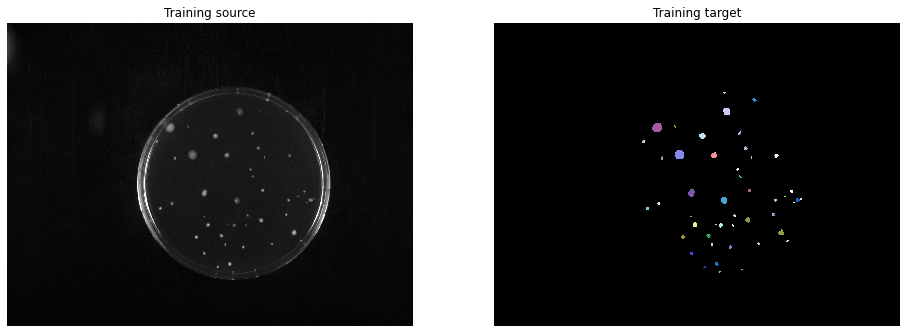

In [ ]:
#@markdown ###Path to training images: 
Training_source = "/content/gdrive/MyDrive/Spline_dist/source" #@param {type:"string"}
Training_target = "/content/gdrive/MyDrive/Spline_dist/target" #@param {type:"string"}


#@markdown ###Name of the model and path to model folder:
model_name = "" #@param {type:"string"}

model_path = "" #@param {type:"string"}
#trained_model = model_path 


#@markdown ### Other parameters for training:
number_of_epochs =  100#@param {type:"number"}
patch_size =  512#@param {type:"number"}

#@markdown ###Advanced Parameters
Use_Default_Advanced_Parameters = True #@param {type:"boolean"}


#@markdown ###If not, please input:

#GPU_limit = 90 #@param {type:"number"}
batch_size =  4#@param {type:"number"}
number_of_steps = 100#@param {type:"number"}
contoursize = 0#@param {type:"number"}
percentage_validation =  10 #@param {type:"number"}
grid_parameter = 2#@param [1, 2, 4, 8, 16, 32] {type:"raw"}
number_of_control_points =  16#@param {type:"number"}
initial_learning_rate = 0.0003 #@param {type:"number"}

if (Use_Default_Advanced_Parameters): 
  print("Default advanced parameters enabled")  
  batch_size = 4
  percentage_validation = 10
  grid_parameter = 2
  number_of_control_points = 16
  initial_learning_rate = 0.0003
  print('Estimating optimal contour size...')
  contoursize = get_contoursize_percentile_from_path(Training_target, 99, False)

else:
  if (contoursize == 0):
    print('Estimating optimal contour size...')
    contoursize = get_contoursize_percentile_from_path(Training_target, 99, True)
  

percentage = percentage_validation/100

#here we check that no model with the same name already exist, if so delete
if os.path.exists(model_path+'/'+model_name):
  print(bcolors.WARNING +"!! WARNING: Folder already exists and has been removed !!" + W)
  shutil.rmtree(model_path+'/'+model_name)
  
# Here we open will randomly chosen input and output image
random_choice = random.choice(os.listdir(Training_source))
x = imread(Training_source+"/"+random_choice)

# Here we check the image dimensions

Image_Y = x.shape[0]
Image_X = x.shape[1]

print('Loaded images (width, length) =', x.shape)


  
#Hyperparameters failsafes

# Here we check that patch_size is smaller than the smallest xy dimension of the image 

if patch_size > min(Image_Y, Image_X):
  patch_size = min(Image_Y, Image_X)
  print(bcolors.WARNING + " Your chosen patch_size is bigger than the xy dimension of your image; therefore the patch_size chosen is now:",patch_size)

if patch_size > 2048:
  patch_size = 2048
  print(bcolors.WARNING + " Your image dimension is large; therefore the patch_size chosen is now:",patch_size)


# Here we check that the patch_size is divisible by 16
if not patch_size % 16 == 0:
    patch_size = ((int(patch_size / 16)-1) * 16)
    print(bcolors.WARNING + " Your chosen patch_size is not divisible by 8; therefore the patch_size chosen is:",patch_size)

# Here we disable pre-trained model by default (in case the next cell is not ran)
Use_pretrained_model = False

# Here we disable data augmentation by default (in case the cell is not ran)

Use_Data_augmentation = False

print("Patch size: ", patch_size)
print("Contour size: ", round(contoursize,2))
print("Parameters initiated.")


os.chdir(Training_target)
y = imread(Training_target+"/"+random_choice)

#Here we use a simple normalisation strategy to visualise the image
norm = simple_norm(x, percent = 99)

f=plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.imshow(x, interpolation='nearest', norm=norm, cmap='magma')
plt.title('Training source')
plt.axis('off');

plt.subplot(1,2,2)
plt.imshow(y, interpolation='nearest', cmap=lbl_cmap)
plt.title('Training target')
plt.axis('off');
plt.savefig('/content/TrainingDataExample_SplineDist2D.png',bbox_inches='tight',pad_inches=0)

## **3.2. Data augmentation**
---
<font size = 4>

<font size = 4>Data augmentation can improve training progress by amplifying differences in the dataset. This can be useful if the available dataset is small since, in this case, it is possible that a network could quickly learn every example in the dataset (overfitting), without augmentation. Augmentation is not necessary for training and if your training dataset is large you should disable it.

<font size = 4>Data augmentation is performed here via random rotations, flips, and intensity changes.


<font size = 4> **However, data augmentation is not a magic solution and may also introduce issues. Therefore, we recommend that you train your network with and without augmentation, and use the QC section to validate that it improves overall performances.** 


In [ ]:
#Data augmentation

Use_Data_augmentation = False #@param {type:"boolean"}

#@markdown ####Choose a factor by which you want to multiply your original dataset

Multiply_dataset_by = 6 #@param {type:"slider", min:1, max:10, step:1}


def random_fliprot(img, mask): 
    assert img.ndim >= mask.ndim
    axes = tuple(range(mask.ndim))
    perm = tuple(np.random.permutation(axes))
    img = img.transpose(perm + tuple(range(mask.ndim, img.ndim))) 
    mask = mask.transpose(perm) 
    for ax in axes: 
        if np.random.rand() > 0.5:
            img = np.flip(img, axis=ax)
            mask = np.flip(mask, axis=ax)
    return img, mask 

def random_intensity_change(img):
    img = img*np.random.uniform(0.6,2) + np.random.uniform(-0.2,0.2)
    return img


def augmenter(x, y):
    """Augmentation of a single input/label image pair.
    x is an input image
    y is the corresponding ground-truth label image
    """
    x, y = random_fliprot(x, y)
    x = random_intensity_change(x)
    # add some gaussian noise
    sig = 0.02*np.random.uniform(0,1)
    x = x + sig*np.random.normal(0,1,x.shape)
    return x, y



if Use_Data_augmentation:
  augmenter = augmenter
  print("Data augmentation enabled")


if not Use_Data_augmentation:
  augmenter = None
  print(bcolors.WARNING+"Data augmentation disabled") 




Data augmentation disabled



## **3.3. Using weights from a pre-trained model as initial weights**
---
<font size = 4>  Here, you can set the the path to a pre-trained model from which the weights can be extracted and used as a starting point for this training session. **This pre-trained model needs to be a SplineDist model**. 

<font size = 4> This option allows you to perform training over multiple Colab runtimes or to do transfer learning using models trained outside of ZeroCostDL4Mic. **You do not need to run this section if you want to train a network from scratch**.

<font size = 4> In order to continue training from the point where the pre-trained model left off, it is adviseable to also **load the learning rate** that was used when the training ended. This is automatically saved for models trained with ZeroCostDL4Mic and will be loaded here. If no learning rate can be found in the model folder provided, the default learning rate will be used. 

In [ ]:
# @markdown ##Loading weights from a pre-trained network


Use_pretrained_model = False #@param {type:"boolean"}

pretrained_model_choice = "Model_from_file" #@param ["Model_from_file"]

Weights_choice = "best" #@param ["last", "best"]


#@markdown ###If you chose "Model_from_file", please provide the path to the model folder:
pretrained_model_path = "/content/gdrive/MyDrive/Spline_dist_augmented_actual/Chr_spline_dist" #@param {type:"string"}

# --------------------- Check if we load a previously trained model ------------------------
if Use_pretrained_model:

# --------------------- Load the model from the choosen path ------------------------
  if pretrained_model_choice == "Model_from_file":
    h5_file_path = os.path.join(pretrained_model_path, "weights_"+Weights_choice+".h5")



# --------------------- Add additional pre-trained models here ------------------------



# --------------------- Check the model exist ------------------------
# If the model path chosen does not contain a pretrain model then use_pretrained_model is disabled, 
  if not os.path.exists(h5_file_path):
    print(bcolors.WARNING+'WARNING: weights_last.h5 pretrained model does not exist' + W)
    Use_pretrained_model = False

  
# If the model path contains a pretrain model, we load the training rate, 
  if os.path.exists(h5_file_path):
#Here we check if the learning rate can be loaded from the quality control folder
    if os.path.exists(os.path.join(pretrained_model_path, 'Quality Control', 'training_evaluation.csv')):

      with open(os.path.join(pretrained_model_path, 'Quality Control', 'training_evaluation.csv'),'r') as csvfile:
        csvRead = pd.read_csv(csvfile, sep=',')
        #print(csvRead)
    
        if "learning rate" in csvRead.columns: #Here we check that the learning rate column exist (compatibility with model trained un ZeroCostDL4Mic bellow 1.4)
          print("pretrained network learning rate found")
          #find the last learning rate
          lastLearningRate = csvRead["learning rate"].iloc[-1]
          #Find the learning rate corresponding to the lowest validation loss
          min_val_loss = csvRead[csvRead['val_loss'] == min(csvRead['val_loss'])]
          #print(min_val_loss)
          bestLearningRate = min_val_loss['learning rate'].iloc[-1]

          if Weights_choice == "last":
            print('Last learning rate: '+str(lastLearningRate))

          if Weights_choice == "best":
            print('Learning rate of best validation loss: '+str(bestLearningRate))

        if not "learning rate" in csvRead.columns: #if the column does not exist, then initial learning rate is used instead
          bestLearningRate = initial_learning_rate
          lastLearningRate = initial_learning_rate
          print(bcolors.WARNING+'WARNING: The learning rate cannot be identified from the pretrained network. Default learning rate of '+str(bestLearningRate)+' will be used instead' + W)

#Compatibility with models trained outside ZeroCostDL4Mic but default learning rate will be used
    if not os.path.exists(os.path.join(pretrained_model_path, 'Quality Control', 'training_evaluation.csv')):
      print(bcolors.WARNING+'WARNING: The learning rate cannot be identified from the pretrained network. Default learning rate of '+str(initial_learning_rate)+' will be used instead'+ W)
      bestLearningRate = initial_learning_rate
      lastLearningRate = initial_learning_rate


# Display info about the pretrained model to be loaded (or not)
if Use_pretrained_model:
  print('Weights found in:')
  print(h5_file_path)
  print('will be loaded prior to training.')

else:
  print(bcolors.WARNING+'No pretrained network will be used.')



No pretrained network will be used.


#**4. Train the network**
---

## **4.1. Prepare the training data and model for training**
---
<font size = 4>Here, we use the information from 3. to build the model and convert the training data into a suitable format for training.

In [ ]:
#@markdown ##Create the model and dataset objects


Training_source_dir = Training_source
Training_target_dir = Training_target
# --------------------- ------------------------------------------------

training_images_tiff=Training_source_dir+"/*.tif"
mask_images_tiff=Training_target_dir+"/*.tif"

# this funtion imports training images and masks and sorts them suitable for the network
X = sorted(glob(training_images_tiff))   
Y = sorted(glob(mask_images_tiff))   

# assert -funtion check that X and Y really have images. If not this cell raises an error
assert all(Path(x).name==Path(y).name for x,y in zip(X,Y))

# Here we map the training dataset (images and masks).
X = list(map(imread,X))
Y = list(map(imread,Y))
n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]

#Normalize images and fill small label holes.
if n_channel == 1:
  axis_norm = (0,1)   # normalize channels independently
  print("Normalizing image channels independently")

if n_channel > 1:
  axis_norm = (0,1,2) # normalize channels jointly
  print("Normalizing image channels jointly")  
  sys.stdout.flush()


X = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(X)]
Y = [fill_label_holes(y) for y in tqdm(Y)]

#Here we split the training dataset into training images (90 %) and validation images (10 %). 
#It is advisable to use 10 % of your training dataset for validation. This ensures the truthfull validation error value. If only few validation images are used network may choose too easy or too challenging images for validation. 
# split training data (images and masks) into training images and validation images.
assert len(X) > 1, "not enough training data"
rng = np.random.RandomState(42)
ind = rng.permutation(len(X))
n_val = max(1, int(round(percentage * len(ind))))
ind_train, ind_val = ind[:-n_val], ind[-n_val:]
X_val, Y_val = [X[i] for i in ind_val]  , [Y[i] for i in ind_val]
X_trn, Y_trn = [X[i] for i in ind_train], [Y[i] for i in ind_train] 
print('number of images: %3d' % len(X))
print('- training:       %3d' % len(X_trn))
print('- validation:     %3d' % len(X_val))

# Use OpenCL-based computations for data generator during training (requires 'gputools')
# Currently always False for stability
use_gpu = False and gputools_available()

#Here we ensure that our network has a minimal number of steps

if (Use_Default_Advanced_Parameters) or (number_of_steps == 0):
  # number_of_steps = (int(len(X)/batch_size)+1)
  number_of_steps = Image_X*Image_Y/(patch_size*patch_size)*(int(len(X)/batch_size)+1)
  if (Use_Data_augmentation):
    augmentation_factor = Multiply_dataset_by
    number_of_steps = number_of_steps * augmentation_factor

print('Number of steps: '+str(number_of_steps))

# --------------------- Using pretrained model ------------------------
#Here we ensure that the learning rate set correctly when using pre-trained models
if Use_pretrained_model:
  if Weights_choice == "last":
    initial_learning_rate = lastLearningRate

  if Weights_choice == "best":            
    initial_learning_rate = bestLearningRate
# --------------------- ---------------------- ------------------------

# # compute the size of the largest contour present in the image-set
# Now executed above
# if contoursize_max == 0:
#   # contoursize_max = get_contoursize_max(Y_trn)
#   contoursize_99p = get_contoursize_percentile(Y_trn, 99) # 99th percentile

# # print('Maximum contour size: '+str(contoursize_max))
# print('99th percentile contour size: '+str(contoursize_99p))


conf = Config2D (
    use_gpu      = use_gpu,
    train_batch_size = batch_size,
    n_channel_in = n_channel,
    train_patch_size = (patch_size, patch_size),
    grid = (grid_parameter, grid_parameter),
    train_learning_rate = initial_learning_rate,
    n_params        = 2*number_of_control_points,
    contoursize_max = contoursize,
)


# Here we create a model according to section 5.3.
model = SplineDist2D(conf, name=model_name, basedir=model_path)

os.chdir(model_path+'/'+model_name)
phi_generator(number_of_control_points, conf.contoursize_max)
grid_generator(number_of_control_points, conf.train_patch_size, conf.grid)


# --------------------- Using pretrained model ------------------------
# Load the pretrained weights 
if Use_pretrained_model:
  model.load_weights(h5_file_path)


# --------------------- ---------------------- ------------------------

#Here we check the FOV of the network.
median_size = calculate_extents(list(Y), np.median)
fov = np.array(model._axes_tile_overlap('YX'))
if any(median_size > fov):
    print(bcolors.WARNING+"WARNING: median object size larger than field of view of the neural network.")
print(conf)

#Export pdf summary of training parameters
pdf_export(augmentation = Use_Data_augmentation, pretrained_model = Use_pretrained_model)



Normalizing image channels jointly


100%|██████████| 12/12 [00:00<00:00, 25.36it/s]


number of images:  12
- training:        11
- validation:       1
Number of steps: 58.598297119140625
Using default values: prob_thresh=0.5, nms_thresh=0.4.
Config2D(axes='YXC', backbone='unet', contoursize_max=146, grid=(2, 2), n_channel_in=3, n_channel_out=33, n_dim=2, n_params=32, net_conv_after_unet=128, net_input_shape=(None, None, 3), net_mask_shape=(None, None, 1), train_background_reg=0.0001, train_batch_size=4, train_checkpoint='weights_best.h5', train_checkpoint_epoch='weights_now.h5', train_checkpoint_last='weights_last.h5', train_completion_crop=32, train_dist_loss='mae', train_epochs=400, train_foreground_only=0.9, train_learning_rate=0.0003, train_loss_weights=(1, 0.2), train_n_val_patches=None, train_patch_size=(512, 512), train_reduce_lr={'factor': 0.5, 'patience': 40, 'min_delta': 0}, train_shape_completion=False, train_steps_per_epoch=100, train_tensorboard=True, unet_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_kernel_size=(3, 3), unet_last_activa

## **4.2. Start training**
---
<font size = 4>When playing the cell below you should see updates after each epoch (round). Network training can take some time.

<font size = 4>* **CRITICAL NOTE:** Google Colab has a time limit for processing (to prevent using GPU power for datamining). Training time must be less than 12 hours! If training takes longer than 12 hours, please decrease the number of epochs or number of patches. Another way circumvent this is to save the parameters of the model after training and start training again from this point.

<font size = 4>Once training is complete, the trained model is automatically saved on your Google Drive, in the **model_path** folder that was selected in Section 3. It is however wise to download the folder from Google Drive as all data can be erased at the next training if using the same folder.


Epoch 1/100
58/58 [==============================] - 113s 2s/step - loss: 1.5743 - prob_loss: 0.2592 - dist_loss: 6.5752 - prob_kld: 0.2325 - dist_relevant_mae: 6.5501 - dist_relevant_mse: 82.3644 - val_loss: 2.3859 - val_prob_loss: 0.0880 - val_dist_loss: 11.4897 - val_prob_kld: 0.0748 - val_dist_relevant_mae: 11.4646 - val_dist_relevant_mse: 225.8157 - lr: 3.0000e-04
Epoch 2/100
58/58 [==============================] - 103s 2s/step - loss: 1.1283 - prob_loss: 0.0906 - dist_loss: 5.1884 - prob_kld: 0.0689 - dist_relevant_mae: 5.1634 - dist_relevant_mse: 54.3568 - val_loss: 2.1497 - val_prob_loss: 0.0595 - val_dist_loss: 10.4510 - val_prob_kld: 0.0463 - val_dist_relevant_mae: 10.4259 - val_dist_relevant_mse: 191.0976 - lr: 3.0000e-04
Epoch 3/100
58/58 [==============================] - 107s 2s/step - loss: 1.0724 - prob_loss: 0.0775 - dist_loss: 4.9742 - prob_kld: 0.0556 - dist_relevant_mae: 4.9493 - dist_relevant_mse: 49.2368 - val_loss: 2.0361 - val_prob_loss: 0.0563 - val_dist_loss:

NMS threshold = 0.5:  75%|███████▌  | 15/20 [00:16<00:05,  1.10s/it, 0.571 -> 0.756]


Using optimized values: prob_thresh=0.555, nms_thresh=0.3.
Saving to 'thresholds.json'.
Done
Time elapsed: 2.0 hour(s) 48.0 min(s) 52 sec(s)


100%|██████████| 1/1 [00:01<00:00,  1.90s/it]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


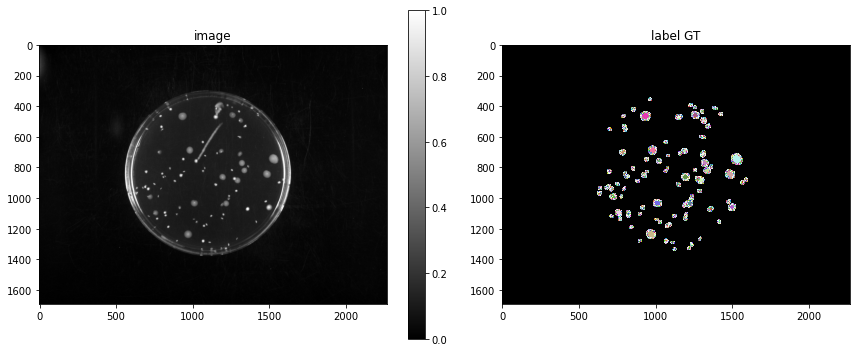

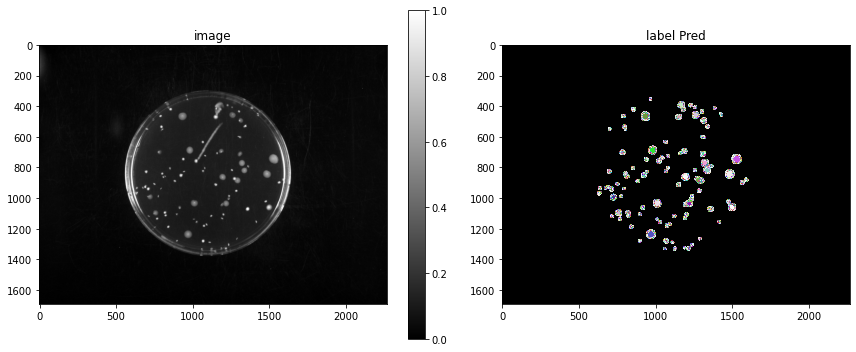

In [ ]:
start = time.time()

#@markdown ##Start training

# Training the model. 

history = model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=augmenter,
                      epochs=number_of_epochs, steps_per_epoch=number_of_steps)


print("Training done")

print("Network optimization in progress")
#Here we optimize the network.

model.optimize_thresholds(X_val, Y_val)

print("Done")


# convert the history.history dict to a pandas DataFrame:     
lossData = pd.DataFrame(history.history) 

if os.path.exists(model_path+"/"+model_name+"/Quality Control"):
  shutil.rmtree(model_path+"/"+model_name+"/Quality Control")

os.makedirs(model_path+"/"+model_name+"/Quality Control")

# The training evaluation.csv is saved (overwrites the Files if needed). 
lossDataCSVpath = model_path+'/'+model_name+'/Quality Control/training_evaluation.csv'
with open(lossDataCSVpath, 'w') as f:
  writer = csv.writer(f)
  writer.writerow(['loss','val_loss', 'learning rate'])
  for i in range(len(history.history['loss'])):
    writer.writerow([history.history['loss'][i], history.history['val_loss'][i], history.history['lr'][i]])

# Displaying the time elapsed for training
dt = time.time() - start
mins, sec = divmod(dt, 60) 
hour, mins = divmod(mins, 60) 
print("Time elapsed:",hour, "hour(s)",mins,"min(s)",round(sec),"sec(s)")

#Create a pdf document with training summary
pdf_export(trained = True, augmentation = Use_Data_augmentation, pretrained_model = Use_pretrained_model)

# Displaying the validation data

Y_val_pred = [model.predict_instances(x, n_tiles=model._guess_n_tiles(x), show_tile_progress=False)[0]
              for x in tqdm(X_val)]

def plot_img_label(img, lbl, img_title="image", lbl_title="label", **kwargs):
  fig, (ai,al) = plt.subplots(1,2, figsize=(12,5), gridspec_kw=dict(width_ratios=(1.25,1)))
  im = ai.imshow(img, cmap='gray', clim=(0,1))
  ai.set_title(img_title)    
  fig.colorbar(im, ax=ai)
  al.imshow(lbl, cmap=lbl_cmap)
  al.set_title(lbl_title)
  plt.tight_layout()

plot_img_label(X_val[0],Y_val[0], lbl_title="label GT")
plot_img_label(X_val[0],Y_val_pred[0], lbl_title="label Pred")



# **5. Evaluate your model**
---

<font size = 4>This section allows the user to perform important quality checks on the validity and generalisability of the trained model. 

<font size = 4>**We highly recommend to perform quality control on all newly trained models.**



In [ ]:
# model name and path
#@markdown ###Do you want to assess the model you just trained ?
Use_the_current_trained_model = False #@param {type:"boolean"}

#@markdown ###If not, please provide the path to the model folder:

QC_model_folder = "/content/gdrive/MyDrive/Spline_dist/Chr_spline_dist_noaug" #@param {type:"string"}

#Here we define the loaded model name and path
QC_model_name = os.path.basename(QC_model_folder)
QC_model_path = os.path.dirname(QC_model_folder)

if (Use_the_current_trained_model): 
  QC_model_name = model_name
  QC_model_path = model_path

full_QC_model_path = QC_model_path+'/'+QC_model_name+'/'
if os.path.exists(full_QC_model_path):
  print("The "+QC_model_name+" network will be evaluated")
else:  
  print(bcolors.WARNING+'!! WARNING: The chosen model does not exist !!')
  print('Please make sure you provide a valid model path and model name before proceeding further.')


The Chr_spline_dist_noaug network will be evaluated


## **5.1. Inspection of the loss function**
---

<font size = 4>First, it is good practice to evaluate the training progress by comparing the training loss with the validation loss. The latter is a metric which shows how well the network performs on a subset of unseen data which is set aside from the training dataset. For more information on this, see for example [this review](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6381354/) by Nichols *et al.*

<font size = 4>**Training loss** describes an error value after each epoch for the difference between the model's prediction and its ground-truth target.

<font size = 4>**Validation loss** describes the same error value between the model's prediction on a validation image and compared to it's target.

<font size = 4>During training both values should decrease before reaching a minimal value which does not decrease further even after more training. Comparing the development of the validation loss with the training loss can give insights into the model's performance.

<font size = 4>Decreasing **Training loss** and **Validation loss** indicates that training is still necessary and increasing the `number_of_epochs` is recommended. Note that the curves can look flat towards the right side, just because of the y-axis scaling. The network has reached convergence once the curves flatten out. After this point no further training is required. If the **Validation loss** suddenly increases again an the **Training loss** simultaneously goes towards zero, it means that the network is overfitting to the training data. In other words the network is remembering the exact patterns from the training data and no longer generalizes well to unseen data. In this case the training dataset has to be increased.

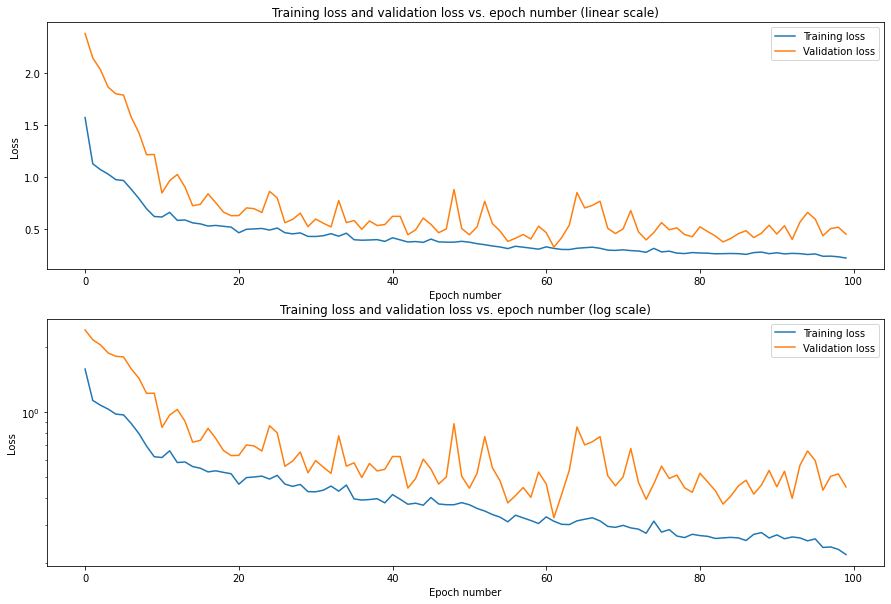

In [ ]:
#@markdown ##Play the cell to show a plot of training errors vs. epoch number

lossDataFromCSV = []
vallossDataFromCSV = []

with open(QC_model_path+'/'+QC_model_name+'/Quality Control/training_evaluation.csv','r') as csvfile:
    csvRead = csv.reader(csvfile, delimiter=',')
    next(csvRead)
    for row in csvRead:
        lossDataFromCSV.append(float(row[0]))
        vallossDataFromCSV.append(float(row[1]))

epochNumber = range(len(lossDataFromCSV))
plt.figure(figsize=(15,10))

plt.subplot(2,1,1)
plt.plot(epochNumber,lossDataFromCSV, label='Training loss')
plt.plot(epochNumber,vallossDataFromCSV, label='Validation loss')
plt.title('Training loss and validation loss vs. epoch number (linear scale)')
plt.ylabel('Loss')
plt.xlabel('Epoch number')
plt.legend()

plt.subplot(2,1,2)
plt.semilogy(epochNumber,lossDataFromCSV, label='Training loss')
plt.semilogy(epochNumber,vallossDataFromCSV, label='Validation loss')
plt.title('Training loss and validation loss vs. epoch number (log scale)')
plt.ylabel('Loss')
plt.xlabel('Epoch number')
plt.legend()
plt.savefig(QC_model_path+'/'+QC_model_name+'/Quality Control/lossCurvePlots.png')
plt.show()



## **5.2. Error mapping and quality metrics estimation**
---
<font size = 4>This section will calculate the Intersection over Union score for all the images provided in the Source_QC_folder and Target_QC_folder ! The result for one of the image will also be displayed.

<font size = 4>The **Intersection over Union** (IuO) metric is a method that can be used to quantify the percent overlap between the target mask and your prediction output. **Therefore, the closer to 1, the better the performance.** This metric can be used to assess the quality of your model to accurately predict nuclei. 

<font size = 4>Here, the IuO is both calculated over the whole image and on a per-object basis. The value displayed below is the IuO value calculated over the entire image. The IuO value calculated on a per-object basis is used to calculate the other metrics displayed.

<font size = 4>“n_true” refers to the number of objects present in the ground truth image. “n_pred” refers to the number of objects present in the predicted image. 

<font size = 4>When a segmented object has an IuO value above 0.5 (compared to the corresponding ground truth), it is then considered a true positive. The number of “**true positives**” is available in the table below. The number of “false positive” is then defined as  “**false positive**” = “n_pred” - “true positive”. The number of “false negative” is defined as “false negative” = “n_true” - “true positive”.

<font size = 4>The mean_matched_score is the mean IoUs of matched true positives. The mean_true_score is the mean IoUs of matched true positives but normalized by the total number of ground truth objects. The panoptic_quality is calculated as described by [Kirillov et al. 2019](https://arxiv.org/abs/1801.00868).

<font size = 4>For more information about the other metric displayed, please consult the SI of the paper describing ZeroCostDL4Mic.

<font size = 4> The results can be found in the "*Quality Control*" folder which is located inside your "model_folder".

In [ ]:
#@markdown ##Choose the folders that contain your Quality Control dataset

Source_QC_folder = "/content/gdrive/MyDrive/Spline_dist/qc_source" #@param{type:"string"}
Target_QC_folder = "/content/gdrive/MyDrive/Spline_dist/qc_target" #@param{type:"string"}


#Create a quality control Folder and check if the folder already exist
if os.path.exists(QC_model_path+"/"+QC_model_name+"/Quality Control") == False:
  os.makedirs(QC_model_path+"/"+QC_model_name+"/Quality Control")

if os.path.exists(QC_model_path+"/"+QC_model_name+"/Quality Control/Prediction"):
  shutil.rmtree(QC_model_path+"/"+QC_model_name+"/Quality Control/Prediction")

os.makedirs(QC_model_path+"/"+QC_model_name+"/Quality Control/Prediction")


# Generate predictions from the Source_QC_folder and save them in the QC folder

Source_QC_folder_tif = Source_QC_folder+"/*.tif"

np.random.seed(16)
lbl_cmap = random_label_cmap()
Z = sorted(glob(Source_QC_folder_tif))
Z = list(map(imread,Z))
n_channel = 1 if Z[0].ndim == 2 else Z[0].shape[-1]

print('Number of test dataset found in the folder: '+str(len(Z)))
  
#Normalize images.

if n_channel == 1:
  axis_norm = (0,1)   # normalize channels independently
  print("Normalizing image channels independently")

if n_channel > 1:
  axis_norm = (0,1,2) # normalize channels jointly
  print("Normalizing image channels jointly") 

model = SplineDist2D(None, name=QC_model_name, basedir=QC_model_path)
names = [os.path.basename(f) for f in sorted(glob(Source_QC_folder_tif))]
 
# modify the names to suitable form: path_images/image_numberX.tif
  
lenght_of_Z = len(Z)
  
print('Running predictions...')
for i in tqdm(range(lenght_of_Z)):
  img = normalize(Z[i], 1,99.8, axis=axis_norm)
  os.chdir(QC_model_path+"/"+QC_model_name)
  labels, details = model.predict_instances(img)
  os.chdir(QC_model_path+"/"+QC_model_name+"/Quality Control/Prediction")
  imsave(names[i], labels, details)



# Here we start testing the differences between GT and predicted masks


with open(QC_model_path+"/"+QC_model_name+"/Quality Control/Quality_Control for "+QC_model_name+".csv", "w", newline='') as file:
  writer = csv.writer(file)
  writer.writerow(["image","Prediction v. GT Intersection over Union", "false positive", "true positive", "false negative", "precision", "recall", "accuracy", "f1 score", "n_true", "n_pred", "mean_true_score", "mean_matched_score", "panoptic_quality"])  

# define the images

  for n in os.listdir(Source_QC_folder):
    
    if not os.path.isdir(os.path.join(Source_QC_folder,n)):
      print('Running QC on: '+n)
      test_input = io.imread(os.path.join(Source_QC_folder,n))
      test_prediction = io.imread(os.path.join(QC_model_path+"/"+QC_model_name+"/Quality Control/Prediction",n))
      test_ground_truth_image = io.imread(os.path.join(Target_QC_folder, n))

      # Calculate the matching (with IoU threshold `thresh`) and all metrics
      
      stats = matching(test_ground_truth_image, test_prediction, thresh=0.5)


      #Convert pixel values to 0 or 255
      test_prediction_0_to_255 = test_prediction
      test_prediction_0_to_255[test_prediction_0_to_255>0] = 255

      #Convert pixel values to 0 or 255
      test_ground_truth_0_to_255 = test_ground_truth_image
      test_ground_truth_0_to_255[test_ground_truth_0_to_255>0] = 255


      # Intersection over Union metric

      intersection = np.logical_and(test_ground_truth_0_to_255, test_prediction_0_to_255)
      union = np.logical_or(test_ground_truth_0_to_255, test_prediction_0_to_255)
      iou_score =  np.sum(intersection) / np.sum(union)
      writer.writerow([n, str(iou_score), str(stats.fp), str(stats.tp), str(stats.fn), str(stats.precision), str(stats.recall), str(stats.accuracy), str(stats.f1), str(stats.n_true), str(stats.n_pred), str(stats.mean_true_score), str(stats.mean_matched_score), str(stats.panoptic_quality)])




df = pd.read_csv (QC_model_path+"/"+QC_model_name+"/Quality Control/Quality_Control for "+QC_model_name+".csv")
print(tabulate(df, headers='keys', tablefmt='psql'))




# ------------- For display ------------
print('--------------------------------------------------------------')
@interact
def show_QC_results(file = os.listdir(Source_QC_folder)):
  

  plt.figure(figsize=(25,5))
  source_image = io.imread(os.path.join(Source_QC_folder, file), as_gray = True)
  target_image = io.imread(os.path.join(Target_QC_folder, file), as_gray = True)
  prediction = io.imread(QC_model_path+"/"+QC_model_name+"/Quality Control/Prediction/"+file, as_gray = True)

  stats = matching(prediction, target_image, thresh=0.5)

  target_image_mask = np.empty_like(target_image)
  target_image_mask[target_image > 0] = 255
  target_image_mask[target_image == 0] = 0
  
  prediction_mask = np.empty_like(prediction)
  prediction_mask[prediction > 0] = 255
  prediction_mask[prediction == 0] = 0

  intersection = np.logical_and(target_image_mask, prediction_mask)
  union = np.logical_or(target_image_mask, prediction_mask)
  iou_score =  np.sum(intersection) / np.sum(union)

  norm = simple_norm(source_image, percent = 99)

  
  #Input
  plt.subplot(1,4,1)
  plt.axis('off')
  plt.imshow(source_image, aspect='equal', norm=norm, cmap='magma', interpolation='nearest')
  plt.title('Input')

  #Ground-truth
  plt.subplot(1,4,2)
  plt.axis('off')
  plt.imshow(target_image_mask, aspect='equal', cmap='Greens')
  plt.title('Ground Truth')

  #Prediction
  plt.subplot(1,4,3)
  plt.axis('off')
  plt.imshow(prediction_mask, aspect='equal', cmap='Purples')
  plt.title('Prediction')

  #Overlay
  plt.subplot(1,4,4)
  plt.axis('off')
  plt.imshow(target_image_mask, cmap='Greens')
  plt.imshow(prediction_mask, alpha=0.5, cmap='Purples')
  plt.title('Ground Truth and Prediction, Intersection over Union:'+str(round(iou_score,3 )));
  plt.savefig(full_QC_model_path+'/Quality Control/QC_example_data.png',bbox_inches='tight',pad_inches=0)

qc_pdf_export()

Number of test dataset found in the folder: 4
Normalizing image channels jointly
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.555, nms_thresh=0.3.
Running predictions...


100%|██████████| 4/4 [00:20<00:00,  5.19s/it]


Running QC on: choline_d7_2.tif
Running QC on: choline_d6_1.tif
Running QC on: choline_d7_1.tif
Running QC on: choline_d6_2.tif
+----+------------------+--------------------------------------------+------------------+-----------------+------------------+-------------+----------+------------+------------+----------+----------+-------------------+----------------------+--------------------+
|    | image            |   Prediction v. GT Intersection over Union |   false positive |   true positive |   false negative |   precision |   recall |   accuracy |   f1 score |   n_true |   n_pred |   mean_true_score |   mean_matched_score |   panoptic_quality |
|----+------------------+--------------------------------------------+------------------+-----------------+------------------+-------------+----------+------------+------------+----------+----------+-------------------+----------------------+--------------------|
|  0 | choline_d7_2.tif |                                   0.6491   |          

interactive(children=(Dropdown(description='file', options=('choline_d7_2.tif', 'choline_d6_1.tif', 'choline_d…

# **6. Using the trained model**

---

<font size = 4>In this section the unseen data is processed using the trained model (in section 4). First, your unseen images are uploaded and prepared for prediction. After that your trained model from section 4 is activated and finally saved into your Google Drive.



## **6.1 Generate prediction(s) from unseen dataset**
---

<font size = 4>In this section the unseen data is processed using the trained model (in section 4). First, your unseen images are uploaded and prepared for prediction. After that your trained model from section 4 is activated and finally saved into your Google Drive.

---

<font size = 4>The current trained model (from section 4.3) can now be used to process images. If an older model needs to be used, please untick the **Use_the_current_trained_model** box and enter the name and path of the model to use. Predicted output images are saved in your **Prediction_folder** folder as restored image stacks (ImageJ-compatible TIFF images).

<font size = 4>**`Data_folder`:** This folder should contains the images that you want to predict using the network that you will train.

<font size = 4>**`Result_folder`:** This folder will contain the predicted output ROI.

<font size = 4>**`Data_type`:** Please indicate if the images you want to predict are single images or stacks


<font size = 4>In SplineDist the following results can be exported:

- The predicted mask images
- A tracking file that can easily be imported into Trackmate to track the nuclei (Stacks only).
- A CSV file that contains the number of nuclei detected per image (single image only). 
- A CSV file that contains the coordinate the centre of each detected nuclei (single image only). 



The Chr_spline_dist_noaug network will be used.
Single images are now being predicted
Performing prediction on: betaine_3m7.tif
Normalizing image channels jointly
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.555, nms_thresh=0.3.
Performing prediction on: betaine_FD7.tif
Normalizing image channels jointly
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.555, nms_thresh=0.3.
Performing prediction on: betaine_4m7.tif
Normalizing image channels jointly
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.555, nms_thresh=0.3.
Performing prediction on: betaine_5m6.tif
Normalizing image channels jointly
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.555, nms_thresh=0.3.
Performing pre

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


One example image is displayed bellow:
---------------------
Predictions completed.


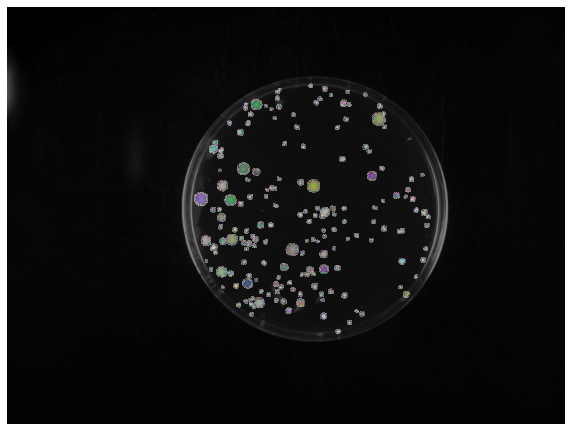

In [3]:
Single_Images = 1
Stacks = 2

#@markdown ### Provide the path to your dataset and to the folder where the prediction will be saved (Result folder), then play the cell to predict output on your unseen images.

Data_folder = "/content/gdrive/MyDrive/Spline_dist/freeze_drying_osmo/Betaine_no_incubation/converted tif" #@param {type:"string"}
Results_folder = "/content/gdrive/MyDrive/Spline_dist/freeze_drying_osmo/Betaine_no_incubation/Results" #@param {type:"string"}

#@markdown ###Are your data single images or stacks?

Data_type = Single_Images #@param ["Single_Images", "Stacks"] {type:"raw"}

#@markdown ###What outputs would you like to generate?

Mask_images = True #@param {type:"boolean"}
Tracking_file = False #@param {type:"boolean"}


# model name and path
#@markdown ###Do you want to use the current trained model?
Use_the_current_trained_model = False #@param {type:"boolean"}

#@markdown ###If not, please provide the path to the model folder:

Prediction_model_folder = "/content/gdrive/MyDrive/Spline_dist/Chr_spline_dist_noaug" #@param {type:"string"}

#Here we find the loaded model name and parent path
Prediction_model_name = os.path.basename(Prediction_model_folder)
Prediction_model_path = os.path.dirname(Prediction_model_folder)

if (Use_the_current_trained_model): 
  print("Using current trained network")
  Prediction_model_name = model_name
  Prediction_model_path = model_path

full_Prediction_model_path = Prediction_model_path+'/'+Prediction_model_name+'/'
if os.path.exists(full_Prediction_model_path):
  print("The "+Prediction_model_name+" network will be used.")
else:
  print(bcolors.WARNING+'!! WARNING: The chosen model does not exist !!'+W)
  print('Please make sure you provide a valid model path and model name before proceeding further.')

#single images

if Data_type == 1 :
  print("Single images are now being predicted")

  Nuclei_number = []

  for image in os.listdir(Data_folder):

    print("Performing prediction on: "+image)
  
    X = imread(Data_folder+"/"+image)
    n_channel = 1 if X.ndim == 2 else X.shape[-1]  
  
    if n_channel == 1:
      axis_norm = (0,1)   # normalize channels independently
      print("Normalizing image channels independently")

    if n_channel > 1:
      axis_norm = (0,1,2) # normalize channels jointly
      print("Normalizing image channels jointly")  
      sys.stdout.flush()
  
    model = SplineDist2D(None, name = Prediction_model_name, basedir = Prediction_model_path)
    names = [os.path.basename(f) for f in sorted(glob(Data_folder))]
    
    short_name = os.path.splitext(image)    

  # Save all ROIs and masks into results folder  

    img = normalize(X, 1,99.8, axis = axis_norm)    
    os.chdir(full_Prediction_model_path)
    labels, details = model.predict_instances(img)    
    os.chdir(Results_folder)

    if Mask_images:
      imsave(str(short_name[0])+".tif", labels, compress=ZIP_DEFLATED)
    
    if Tracking_file:
      print(bcolors.WARNING+"Tracking files are only generated when stacks are predicted"+W)  
    
    Nuclei_centre_coordinate = details['points']
    my_df2 = pd.DataFrame(Nuclei_centre_coordinate)
    my_df2.columns =['Y', 'X']
    
    my_df2.to_csv(Results_folder+'/'+str(short_name[0])+'_object_centre.csv', index=False, header=True)

    Nuclei_array = details['coord']
    Nuclei_array2 = [str(short_name[0]), Nuclei_array.shape[0]]
    Nuclei_number.append(Nuclei_array2) 

  my_df = pd.DataFrame(Nuclei_number)
  my_df.to_csv(Results_folder+'/object_count.csv', index=False, header=False)
  

  # One example is displayed

  print("One example image is displayed bellow:")
  plt.figure(figsize=(10,10))
  plt.imshow(img if img.ndim==2 else img[...,:3], clim=(0,1), cmap='gray')
  plt.imshow(labels, cmap=lbl_cmap, alpha=0.5)
  plt.axis('off');
  plt.savefig(str(short_name[0])+"_overlay.tif")

if Data_type == 2 :
  print("Stacks are being predicted")
  np.random.seed(42)
  lbl_cmap = random_label_cmap()

  # normalize channels independently
  axis_norm = (0,1)  
  print("Normalizing image channels independently")
  
  #Load a pretrained network
  model = SplineDist2D(None, name = Prediction_model_name, basedir = Prediction_model_path)  

  for image in os.listdir(Data_folder):
    print("Performing prediction on: "+image)

    timelapse = imread(Data_folder+"/"+image)

    short_name = os.path.splitext(image)

    timelapse = normalize(timelapse, 1,99.8, axis=(0,)+tuple(1+np.array(axis_norm)))    

    n_timepoint = timelapse.shape[0]
    prediction_stack = np.zeros((n_timepoint, timelapse.shape[1], timelapse.shape[2]))
    
    Tracking_stack = np.zeros((n_timepoint, timelapse.shape[2], timelapse.shape[1]))

# Save the masks in the result folder
    if Mask_images or Tracking_file:
      for t in tqdm(range(n_timepoint)):
        img_t = timelapse[t]
        os.chdir(full_Prediction_model_path)
        labels, details = model.predict_instances(img_t)      
        prediction_stack[t] = labels

# Create a tracking file for trackmate

        for point in details['points']:
          cv2.circle(Tracking_stack[t],tuple(point),0,(1), -1)

      prediction_stack_32 = img_as_float32(prediction_stack, force_copy=False)

      Tracking_stack_32 = img_as_float32(Tracking_stack, force_copy=False)
      Tracking_stack_8 = img_as_ubyte(Tracking_stack_32, force_copy=True)
      
      Tracking_stack_8_rot = np.rot90(Tracking_stack_8, axes=(1,2))
      Tracking_stack_8_rot_flip = np.fliplr(Tracking_stack_8_rot)

      os.chdir(Results_folder)
      if Mask_images:
        imsave("Predicted_"+str(short_name[0]+".tif"), prediction_stack_32, compress=ZIP_DEFLATED)
      if Tracking_file:
        imsave(str(short_name[0])+"_tracking_file.tif", Tracking_stack_8_rot_flip, compress=ZIP_DEFLATED)
          
print('---------------------')
print("Predictions completed.")   

## **6.2. Download your predictions**
---

<font size = 4>**Store your data** and ALL its results elsewhere by downloading it from Google Drive and after that clean the original folder tree (datasets, results, trained model etc.) if you plan to train or use new networks. Please note that the notebook will otherwise **OVERWRITE** all files which have the same name.

# **7. Version log**

<font size = 4>**v1.13.1**: 

* bug fixe: StarDist is now installed via PIP to resolve issues related to missing packages

---
<font size = 4>**v1.13**: 
* This version now includes an automatic restart allowing to set the h5py library to v2.10 and to upgrade Numpy to the latest version. 
* The section 1 and 2 are now swapped for better export of *requirements.txt*. 
* This version also now includes built-in version check and the version log that you're reading now. 
* This version also specifically pulls StarDist packages version 0.6.2, due to current incompatibilities with the newest versions.

---


#**Thank you for using SplineDist 2D!**